# Feature Engineering Demo with PCA

Let me start this notebook with a quote from well-known CS researcher and Data Scientist Pedro Domingos' famous paper [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf).

“At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. If you have many independent features that each correlate well with the class, learning is easy. On the other hand, if the class is a very complex function of the features, you may not be able to learn it. Often, the raw data is not in a form that is amenable to learning, but you can construct features from it that are. This is typically where most of the effort in a machine learning project goes.” 

Here, I'll focus on a limited part - feature selection, derived from feature engineering of this quote. And my vehicle to engineer featuires into a new feature representation is Principal Components Analysis (PCA).

P.S. Domingos is awesome. Sample some of his choice quotes [here](https://www.goodreads.com/work/quotes/44223286-the-master-algorithm-how-the-quest-for-the-ultimate-learning-machine-wi?page=4).

In [1]:
# setup chunk
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pandas as pd   # for dataFrame ops
import numpy as np    # for array ops
import time  # to time some funcs

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

This time we use a famous dataset that we'll import from openml.org using some funcs (just run the fetch code, we won't go into the details).

### The MNIST dataset

Chances are any data scientist worth his/her salt would have at some point come across the legendary MNIST handwritten digits database - a collection of 70,000 handwritten digits from various people of all ages all over the US from the late 90s.

These digits are stored as images of size 28x28 *pixels* each. The import will take time, a minute plus perhaps given its large size.  

Aim is to classify each image into what digit it has. Trivial for us humans but nontrivial for machines. 

Behold.

In [7]:
# time dataset import
t1 = time.time()
mnist = fetch_openml('mnist_784', version=1, cache=True)
t2 = time.time()
print("MNIST import took: ", round(t2-t1, 3), " secs")  # 47.2 secs!
print("\n")

MNIST import took:  30.355  secs




In [8]:
print(type(mnist.data))
print(mnist.data.shape)  # features colm

<class 'numpy.ndarray'>
(70000, 784)


In [9]:
# explore dataset
print(mnist.DESCR)  
print("--------------------\n")
print("Dataset dimns are: ", mnist.data.shape)   # data size dimns
print(mnist.target.shape)  # labels colm
print("--------------------\n")

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Since we know that the digits are images, can we know more? 

What kind of images are these? Can we view a few? 

Behold

28*28 =  784




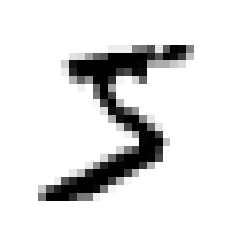

In [10]:
# examine image size in pixels
X, y = mnist["data"], mnist["target"]
print("28*28 = ", 28*28)   # 784. So each digit img is 28^2 pixels in size
print("\n")

# visualize a data point
some_digit = X[0]   # picking the first digit to show
some_digit_image = some_digit.reshape(28, 28)  # reshape pixel vector into 28x28
plt.imshow(some_digit_image, 
           cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

Huh, what digit was that? Are all digits written like this? Would be good to see a few more, no?

However, re-running the above code lines again and again is tiresome. 

So we follow an old programming principle: DRY for 'Don't repeat yourself'.

And the way coders implement DRY is via *functions*. 

So below, I define a couple of funcs that I invoke in a loop and plot a few more digits. 

## Visually Inspecting the Data

Behold.

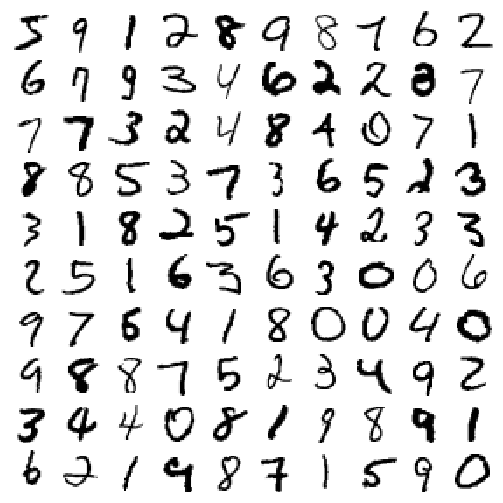

In [11]:
# Wrapper func to plot digits in a matrix
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


# now, finally, plot. whew.
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

How many of these digits above can you correctly identify? How many might the machine identify correctly?

Time now to get to the core classification task. Q now is, **what exactly in the data** will the classifier analyze and classify? 

The input Xs are huge arrays of 784 columns of pixel intensity values, after all. Here is where feature engg comes to the fore. 

Recall factor-an from MKTR. One of its explicit motivations was **dimensionality reduction** and **discovery of latent structure** amongst existing columns **as new variables** ('factors'). IOW, could PCA yield us a new set of features?

## PCA for Feature Engg

To test this, we transform the existing (and possibly sparse, from an informational POV) feature set into a **smaller, condensed, more meaningful set of features using PCA** in this case.

Of course, to evaluate the accuracy, we must have a test sample of unseen data (by the machine) to test things on. For that I start as below with a **train-test-split** routine. 

In [12]:
# train-test-split into 60k:10k
train_x, test_x, train_y, test_y = train_test_split(
    mnist.data, mnist.target, test_size=1/7.0, random_state=0)

print(train_x.shape)
print("\n")
print(test_x.shape)

(60000, 784)


(10000, 784)


### Standardize Data Scale

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

Standardization of a dataset is a common requirement in many ML estimators: they might behave badly if the individual feature scales vary wildly. 

Below, I import the Standard Scaler that scales each colm as a z-score variable.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # instantiate scaler

# Fit on training set only.
scaler.fit(train_x)

# Apply transform to both the training set and the test set.
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

Aim below is to demo how feature engg such as dimensionality reduction can sometimes greatly speed-up ML techniques.

## Getting re-engineered features from PCA

Below, I demo how well ML *learns* patterns in data enough to ID digits accurately, using Logistic classification as an example ML estimator.

Behold.

In [14]:
# import and instantiate model
from sklearn.decomposition import PCA
pca = PCA(.95)  # find min #compts that capture 95% of variance
t1 = time.time()
pca.fit(train_x)
print("PCA fitting on MNIST took: ", round(time.time()-t1, 2), " secs.")  # 8.6 secs
print("\n")
print("Min #compts required is: ", pca.n_components_)  # how many compts meet above criterion? # 327

# Apply the mapping (transform) to both the training set and the test set.
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

PCA fitting on MNIST took:  9.82  secs.


Min #compts required is:  327


There! Seems just 327 out of 784 features (colms) are enough to cpature 95% of variance explained. Whuddathunkit, eh?

Now I invoke the Logistic Regression or LogReg model for the classification task proper. 

LogReg model below learns the relationship between x (digits) and y (labels).

Follows usual path of instantiation, fit, transform and predict.

Caution: When running code below, it's possible the default number of iterations *max)iter* parm might be breached. If so, raise the limit some 5x odd (as I did below). 

In [18]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=500)  # instantiate model

t1 = time.time()
logisticRegr.fit(train_x, train_y)  # fit model on training sample
print("LogReg fitting on MNIST took: ", round(time.time()-t1, 2), " secs.")  # 10 secs

LogReg fitting on MNIST took:  61.62  secs.


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
# Predict for Multiple Observations (images) at Once
pred_vals = logisticRegr.predict(test_x[0:1000]).tolist()

out_df = pd.DataFrame({'Actual_vals': test_y[0:1000], 'Pred_vals':pred_vals})
out_df.head(20)

,Actual_vals,Pred_vals
0,0,0
1,4,4
2,1,1
3,2,2
4,7,4
5,9,7
6,7,7
7,1,1
8,1,1
9,7,7


## Measuring Model Performance

Accuracy is basicallythe fraction of correct predictions, computed as  correct predictions / total number of data points.

This is our mot basic metric of how the model performs on new data (test set). The .score() func computes this for us. 

In [21]:
score = logisticRegr.score(test_x, test_y)
print("accuracy is: ", score)

accuracy is:  0.9181


The original matrix 28x28 for any of the 70k digits is mostly sparse. 

What we did above was PCA to find a condensed set of 327 features that explain 95% of the total variance of the 784 colms (recall factor-an from MKTR!).

Thereafter, we used these 327 features in a classifier and obtained about 92% accuracy. 

Next, we could repeat the above for: 

1. non-PCA under logReg (all 784 colms)

2. PCA with 99% variance explained

3. PCA with 90% variance explained and so on.

I'll leave the details out and present here the results of running such an exercise. Behold. 

In [22]:
pd.DataFrame(data = [[1.00, 784, 48.04, .9158],
                     [.99, 544, 32.39, .9169],
                     [.95, 327, 10.06, .9181],
                     [.90, 238, 8.06, .9168],
                     [.85, 183, 7.65, .9156]], 
             columns = ['Variance Retained',
                      'Number of Components', 
                      'Time (seconds)',
                      'Accuracy'])

,Variance Retained,Number of Components,Time (seconds),Accuracy
0,1.00,784,48.04,0.9158
1,0.99,544,32.39,0.9169
2,0.95,327,10.06,0.9181
3,0.90,238,8.06,0.9168
4,0.85,183,7.65,0.9156


Table above clearly shows a few things.

1. Using all 784 features didn't produce much in accuracy terms. Takes 4x longer to run and yet its actually lower than our 95% figure of 0.9181!

2. Just 327 features out of 784 (less than half) produces the best test sample accuracy. This could likely be peculiar to image data which are large, sparse matrices.

3. Feature engineering and feature selection with PCA demonstrated with LogReg. 

4. We could have used Regularized regressions too with LogReg but that would only give us feature selection, not re-enginnered set of new dense features.

Chalo, back to the slides now.

Voleti. 